In [ ]:
import pandas as pd
import torch
import numpy as np
import seaborn as sns
from torch import nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE, ADASYN
from random import sample
from sklearn.metrics import classification_report

%matplotlib inline

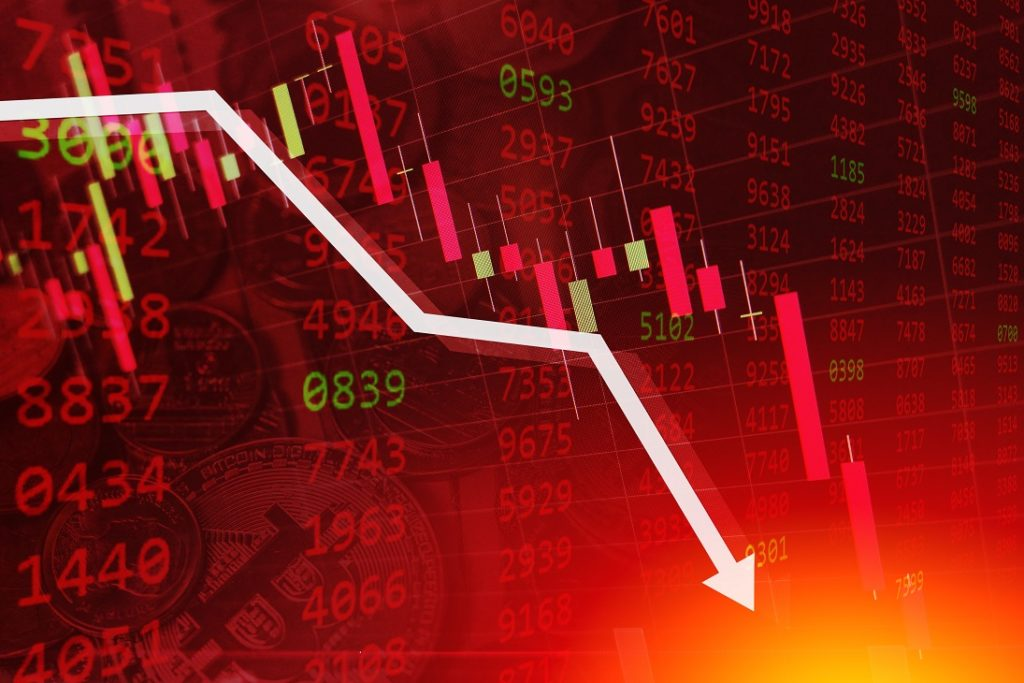

# Taiwanese Bankruptcy Prediction

>The purpose of this project is to predict whether a company is in bankruptcy due to its reported financials. The dataset was collected from the Taiwan Economic Journal for the years 1999-2009. A Deep Learning neural network model will be used as a binary classifier to predict if a company is in bankruptcy or not.

In [ ]:
# Loading the path to the dataset

f = r'../input/company-bankruptcy-prediction/data.csv'

In [ ]:
# Loading the dataset

company = pd.read_csv(f)

In [ ]:
# Exploring the dataset

company.info()

>As shown by the info() method, we now know several important things about this dataset. The first is that there is no missing or null values, which saves us a lot of time. Secondly, all the the variables provided are numerical (int64 or float64). This helps with the model, which can't take categorical variables that are stored as strings or some other non-numeric datatype. Now we can continue to explore some other the aspects of the data.

In [ ]:
company.shape

>Due to the shape of the dataset, we can determine that it contains data on 6819 companies. Each company has 95 variables associated with it, and one column used as a lable of whether the company is in bankruptcy or not.

In [ ]:
# Sample of the data

company.head()

In [ ]:
# Descriptive statistics of the dataset

company.describe()

In [ ]:
# checking to see if the classes in the dataset are imbalanced

p = 1-(len(company[company['Bankrupt?']==1])/len(company))
print(f"Percentage of non-bankrupt companies: {100*p:>8f}%")

In [ ]:
# checking the imbalance 
company['Bankrupt?'].value_counts()

In [ ]:
# Plotting the imbalance

u = list(company['Bankrupt?'].unique())
u.reverse()
vc = list(company['Bankrupt?'].value_counts())
plt.figure(figsize =(10,5))
plt.bar(u,vc, color = ['salmon', 'moccasin'])
plt.xticks(u)
plt.show()

## SMOTE RESAMPLING

>As you can see, there is a significant imbalance in the dataset. This will make it much harder for the model to seperate the two classes. Especially since the model will most likely classify all instances in the dataset as not bankrupt, which would still have a high accuracy score (96.77%). To deal with this imbalance, we will use the SMOTE resampling method. This will create synthetic samples of the smaller class that are similar to the the real class data, balancing the dataset between the two classes.

In [ ]:
# Creating new synthetic data

X = company.drop('Bankrupt?', axis = 1).reset_index(drop = True)
y = company['Bankrupt?'].reset_index(drop = True)
X_resample, y_resample = SMOTE().fit_resample(X,y)

In [ ]:
# Plotting the rebalanced dataset

plt.figure(figsize =(10,5))
plt.bar(u,y_resample.value_counts(), color = ['salmon', 'moccasin'])
plt.xticks(u)
plt.show()

In [ ]:
# Showing that the dataset is now 50/50 between the two classes

y_resample.value_counts()

>Now that we have balanced the dataset, our model is still sensitive to highly correlated variables. These variables would overweight any signal from the data to the neural network. So, lets check the linear correlation of these variables using a heatmap

In [ ]:
# Correlation matrix of dataset

plt.figure(figsize =(30,25))
sns.heatmap(X_resample.corr(), center = 0, cmap = 'coolwarm')

>This dataset isn't too bad, but there is some common correlation between some of the vaiables. Also, this heatmap doesn't show if a variable's variance is explained by multiple other variables, it just shows correlation between pairs of variables. Having a variable's variance that is expainable from multiple other vairables is called multicollinearity, and it causes the same problem as linear correlation by overweighting a signal to the neural network. To measure this multicollinearity, we will calculate the Variance Inflation Factor ( or VIF) for each of the variables in this dataset. A VIF of 1 is the minimum, and means no multicollinearity with the other variables. As the VIF increases, multicollinearity increases.

In [ ]:
# Using the vif_data dataframe to show initial multicollinearity of the dataset

vif_data = pd.DataFrame()
vif_data['Features'] = X_resample.columns
vif_data['VIF'] = [variance_inflation_factor(X_resample.values, i) for i in range(len(X_resample.columns))]
print(vif_data)

> Now we will begin removing the highest VIF scores from the dataset. This is an iterative process, because everytime a variable is removed, the VIF scores of the other variables change. So, we will keep on removing variables and recalculating VIF scores until all variables in the dataset have a VIF below 2.8. 

In [ ]:
# Removing highly related variables

while any(vif_data['VIF']>=2.8):
    i  = vif_data['VIF'].idxmax()
    X_resample.drop(X_resample.columns[i], axis = 1, inplace = True)
    X_resample.reset_index(drop =True)
    vif_data = pd.DataFrame()
    vif_data['Features'] = X_resample.columns
    vif_data['VIF'] = [variance_inflation_factor(X_resample.values, i) for i in range(len(X_resample.columns))]
print(vif_data)
l = len(vif_data)

In [ ]:
# Plotting the heatmap of the transformed data

plt.figure(figsize =(15,10))
sns.heatmap(X_resample.corr(), center = 0, cmap = 'coolwarm')

## Normalization and  Train/Test Splitting

>As shown by the heatmap and VIF scores above, the linear correlation and multicollinearity between the variables have been reduced, and nothing in the dataset should overwieght any signal excessively. The next steps will include normalizing the data, making it easier for the model to learn, and seperating the data into train and test sets.

In [ ]:
# Normalizing the data, saving column names for final classification metrics

c = X_resample.columns
scaler = StandardScaler()
X_resample = pd.DataFrame(scaler.fit_transform(X_resample), columns = X_resample.columns)

In [ ]:
# recasting and spliting the data

X_resample = np.float32(X_resample)
y_resample = np.float32(y_resample)
X_train, X_test,y_train,y_test = train_test_split(X_resample,y_resample,test_size = 0.2, random_state=49)

## Machine Learning Eniviroment Build

> Now we will start building the train/test pipeline for the model. The first step will be creating a dataset object. This object will make it for the pytorch dataloader to split the data into small batches, making computation much easier.

In [ ]:
# Creating the dataset object that will be used in the dataloader

class CreditDataset(Dataset):
    def __init__(self,X,y):
        self.labels = y
        self.X = X
    
    def __getitem__(self,index):
        return self.labels[index], self.X[index]
    
    def __len__(self):
        return len(self.X)
        

In [ ]:
# Initializing the train and test dataloaders

train_dataloader = DataLoader(CreditDataset(X_train,y_train), batch_size = 64)
test_dataloader = DataLoader(CreditDataset(X_test,y_test), batch_size = 64)

>Now we are building the actual neural network. Most classification problems can be solved, as a rule of thumb, with 2 or 3 layers. Exceptions do exist (eg. Computervision), but given this problem is relatively straight foreward, we will only use 3 linear layers. The input to this model will be a 57 dimensional vector from each instance in the dataset, and the output will be a 2 dimensional vector that shows the probability of each company being in bankruptcy or not. ReLU will be used as the activation function, to make the neaural network non-linear. We will also use a dropout layer, which randomly drops a certain percentage of activations from the previous layer. This keeps the model from over relying on a specific varaible and prevents overfitting of the data. Ideally, all of this will improve the accuracy of the data. 

In [ ]:
# Initializing the model

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
        nn.Linear(l,l),
        nn.ReLU(),
        nn.Dropout(p = 0.3),
        nn.Linear(l,l),
        nn.ReLU(),
        nn.Dropout(p = 0.3),
        nn.Linear(l,2)
        )
        
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

> In the last step before we run the model, we need to define the train and test loops. These functions will update the model, allowing it to 'learn' the non-linear relationships between the varibles in the dataset and the probability of bankruptcy for a specific company. The train loop will use the loss and optimization fuctions to update the model, while the test loop will provide us insight into how the model is progressing.

In [ ]:
# Creating the train loop

def train_loop(dataloader, model, loss_fn, optimizer):
    for y,x in dataloader:
        y_pred = model(x)
        loss = loss_fn(y_pred,y.type(torch.long))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
#Creating the test loop

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0,0
    with torch.no_grad():
        for y,x in dataloader:
            y_pred = model(x)
            test_loss += loss_fn(y_pred,y.type(torch.long))
            correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(correct*100):>8f}%, Avg loss: {test_loss:>8f} \n")
            

## Model Initialization and Training

> Finally, we will initalize the model with all of its hyperparameters, and begin the running the train and test loops. The epochs are how many times the model will run against the dataset, in this case 500 times. We will be using pytorch's CrossEntropyLoss function (which combines a Negative Log Likelihood Loss function and a Softmax funtion) to measure the model's performance. Adam will be the optimizing function that actually updates the model's parameters.

In [ ]:
# Initializing the hyperparameters and training the model

epochs = 500
model = NeuralNetwork()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
for i in range(epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

In [ ]:
# Final Report

X_final = company[c]
y_pred_final = model(torch.from_numpy(np.float32(X_final.values)))
target_names = ['class 0','class 1']
print(classification_report(y,y_pred_final.argmax(1),target_names = target_names))


## Final Report

> As shown above, the model was able to learn up to 99% accuracy with the synthetic data. However, with the final report, which only used the real-world data, the f1 scores were lower, significantly lower for the smaller class of bankrupt companies. The final weighted f1 score was 0.95, which is not terrible but not great either given the imbalance in the dataset. I would not recommend this model be used in a professional capacity to determine if a company is about to become bankrupt in the real world, due to the model's bias toward labeling a copmpany as not bankrupt. There are several opprotunities to improve the performance of this model. Some suggestions include experimenting with different synthetic data generation methods, changing the loss function to something that can better handle imbalanced data, as well as trying different machine learning classification models. However, the best path toward improving the model is probably collecting more real-world data on bankrupt, or near-bankrupt, companies to rebalance the dataset. This is also probably the most expensive way to improve the model.